# **MetaboTandem**

# A. Data Pre-processing

# 2. Pre-processing using XCMS

This Notebook allows the preprocessing of the LC-MS/MS data. 
Pre-processing in untargeted metabolomics experiments aims at quantifying the signal from individual ion species in a data set. It consists of 3 main steps: 
- **Chromatographic peak detection**
- **Alignment**
- **Correspondence** 

The resulting matrix of feature abundances can then be used as an input in downstream analyses.


## 2.1 Load libraries

In [84]:
library(xcms)
library(tidyverse)
library(ggpubr)

source('pre_processing_functions.R')

## 2.1 User inputs required <====

Enter below the required data according to the description.
- **data_file:** Path to the `.Rdata` file generated in the prevoius notebook containing the spectra and metadata information 

In [44]:
data_file  <- '../../../data/imported_data.RData'

### 2.1.1 Parameters for peak detection
Enter below the required parameters according to the description.
- **p.width:** Approximate expected peak width in seconds
- **snt:** Signal to noise ratio cutoff
- **noise:** Noise threshold

In [88]:
p.width <- c(10, 100)
snt <- 3
noise <- 1e7

### 2.1.2 Parameters for alignment and correspondence
Enter below the required parameters according to the description.
- **minFraction:** Minimum fraction of samples in at least one group a peak must be present to be considered a peak group
- **minSamples:** Minimum number of samples in at least one group a peak must be present to be considered a peak group
- **binSize:** Size of the overlapping slices in the mz dimension

In [89]:
minFraction <- 0.5 
minSamples <-  1
binSize <- 0.25

## 2.2 Create output directories

In [5]:
# Creating paths for the ouput directories
figures_dir <- file.path('..', '..', '..', 'figures')
tables_dir <- file.path('..', '..', '..', 'tables')

# Create output directories
dir.create(figures_dir, showWarnings = FALSE)
dir.create(tables_dir, showWarnings = FALSE)

## 2.2 Load data

In [90]:
load(data_file)

## 2.3 Initial data visualization

Provides an initial visualization of the **total ion chromatogram (TIC)** and the **base peak chromatogram (BPC)** of your data.

### TIC

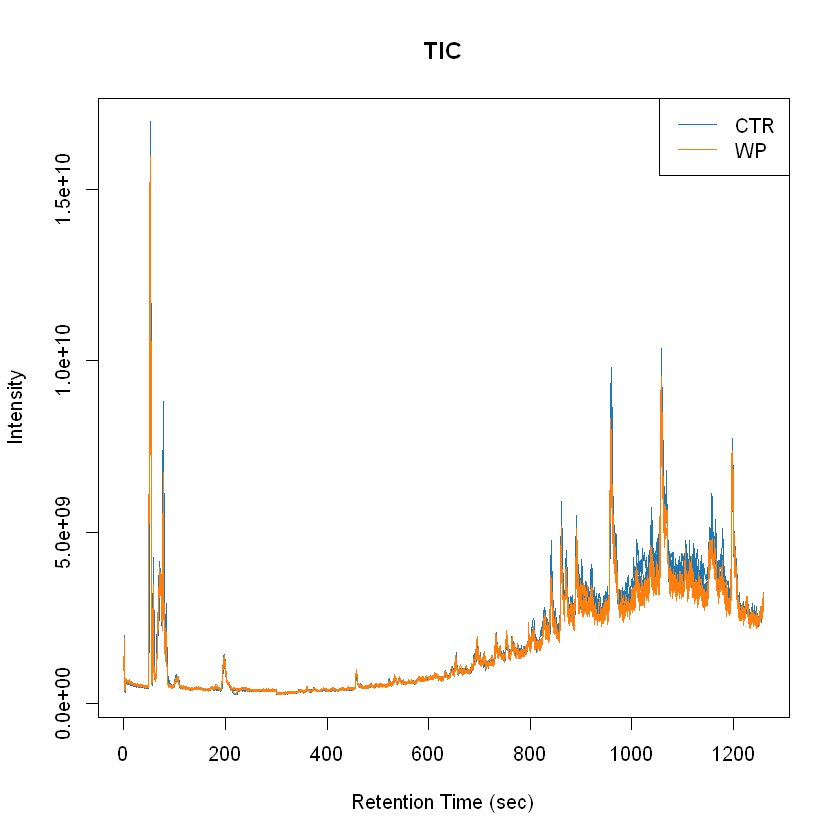

In [18]:
# Extract chromatograms
tic <- calculate_tic(data, color_by = 'treatment', save.figure = file.path(figures_dir, 'a_tic.png'))

### BPC

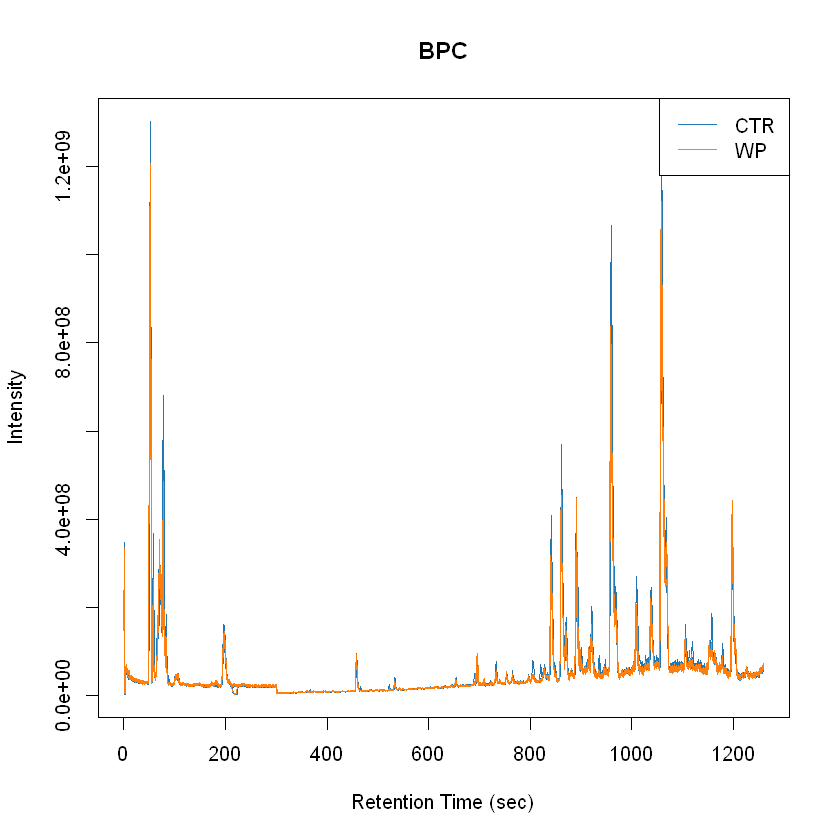

In [21]:
bpc <- calculate_bpc(data, color_by = 'treatment', save.figure = file.path(figures_dir, 'b_bpc.png'))

## 2.4 Chromatographic peak detection

### Testing peak detection parameters

Please enter ranges of masses (*m/z*) and retention times (*rt*, in seconds) for a couple of peaks to visualize how your data respond to the selected parameters

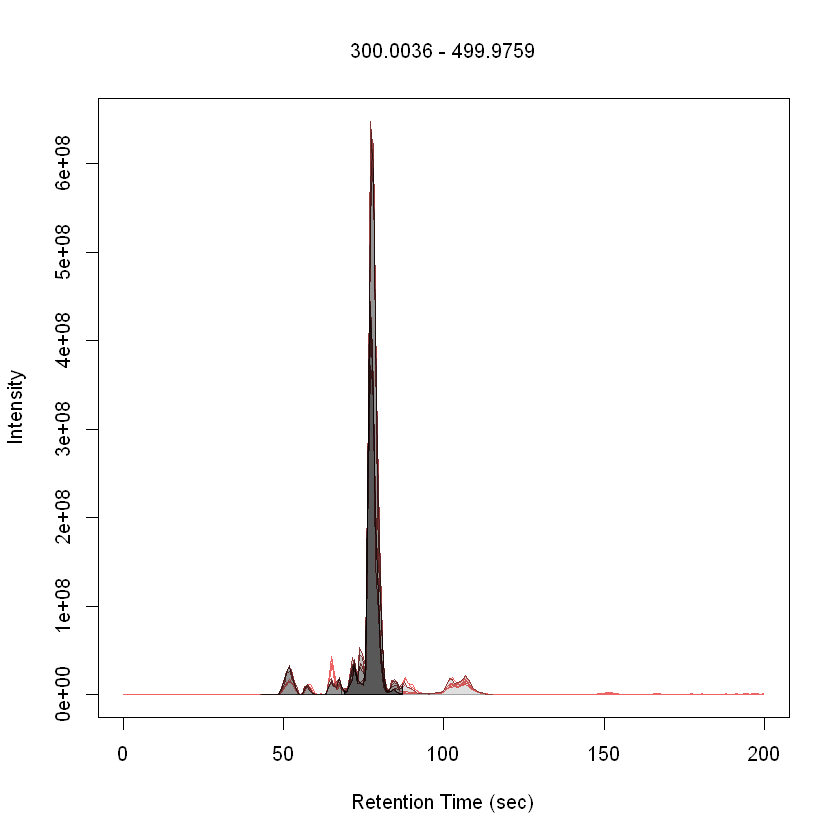

In [91]:
test_peak_picking(data$spectra_centroid, mz.range = c(300, 500), rt.range = c(0, 200), p.width = p.width, snt = snt, noise = noise)

#### Apply on full data

In [92]:
data$spectra_centroid <- apply_peak_picking(data$spectra_centroid, p.width = p.width, snt = snt, noise = noise)


Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")


Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")

#### Extracting peak information

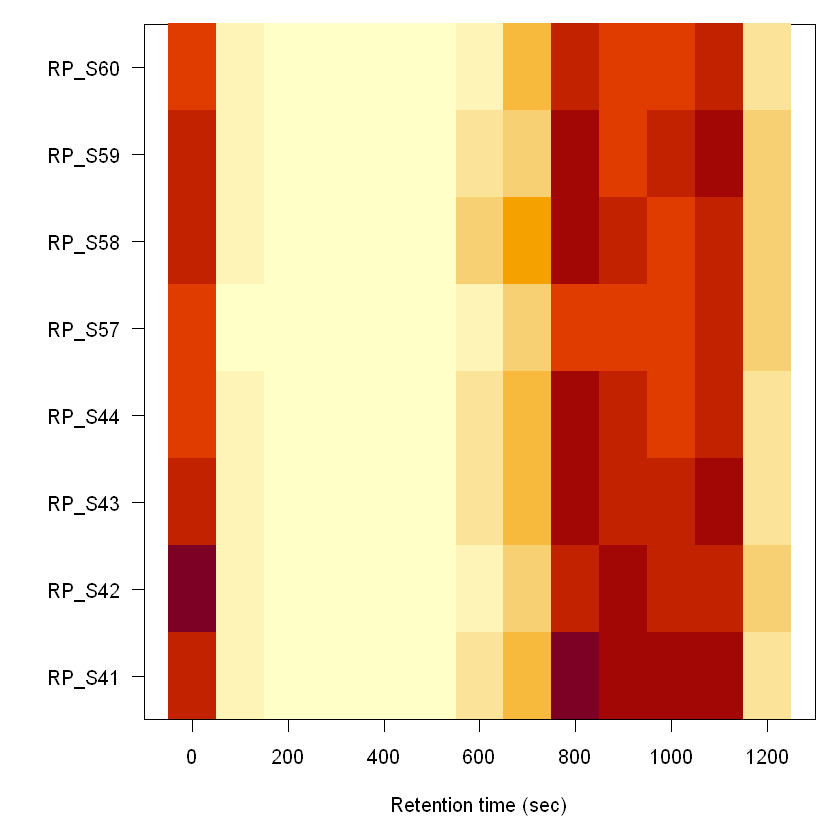

In [93]:
n_peaks_df <- extract_number_peaks(data$spectra_centroid, save.table = file.path(tables_dir, 'a_npeaks.csv'), 
                                   save.figure = file.path(figures_dir, 'c_npeaks_binned.png'))

## 2.5 Alignment

### Aligning data and plotting

#### Plot of adjusted retention time

Processing 4558 mz slices ... 
OK

Performing retention time correction using 122 peak groups.

Warning message:
"Adjusted retention times had to be re-adjusted for some files to ensure them being in the same order than the raw retention times. A call to 'dropAdjustedRtime' might thus fail to restore retention times of chromatographic peaks to their original values. Eventually consider to increase the value of the 'span' parameter."
Applying retention time adjustment to the identified chromatographic peaks ... 
OK



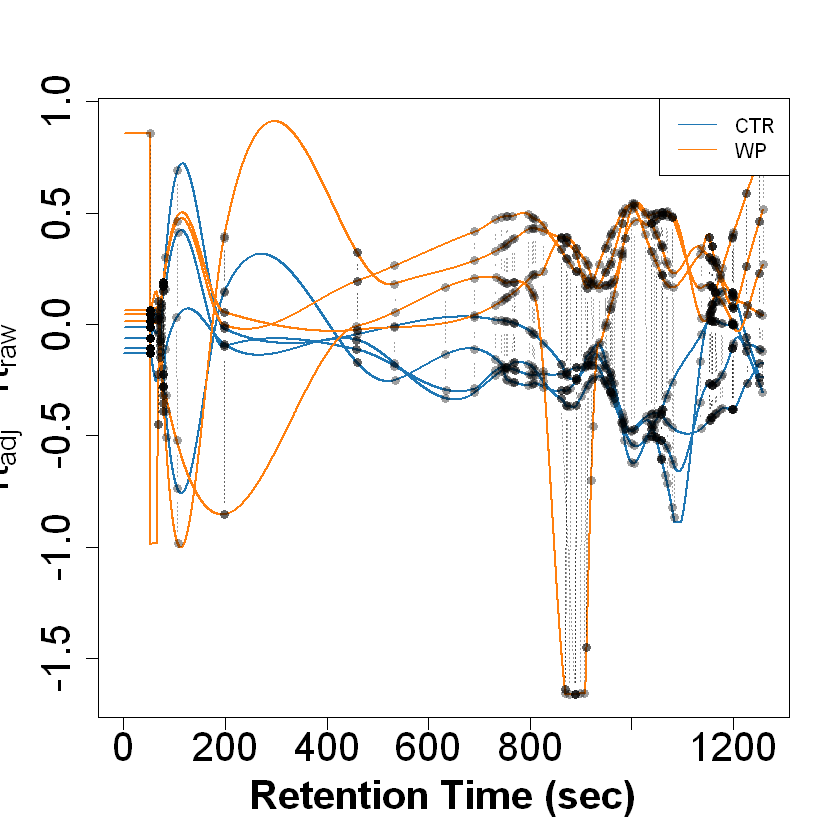

In [94]:
data$spectra_centroid <- apply_alignment(data, minFraction = minFraction, minSamples = minSamples, binSize = binSize, group_by = 'treatment')

## 2.6 Correspondence

### Peak grouping parameters

In [95]:
data$spectra_centroid <- apply_correspondence(data, minFraction = minFraction, minSamples = minSamples, binSize = binSize, group_by = 'treatment')

Processing 4558 mz slices ... 
OK



## 2.7 Gap filling

Missing values occur if no chromatographic peak was assigned to a feature either because peak detection failed, or because the corresponding ion is absent in the respective sample.

In [96]:
data$spectra_centroid <- apply_gap_filling(data)

Defining peak areas for filling-in .
.
.
.
 OK
Start integrating peak areas from original files

Requesting 28 peaks from RP_S41.mzML ... got 23.

Requesting 27 peaks from RP_S42.mzML ... got 19.

Requesting 26 peaks from RP_S43.mzML ... got 14.

Requesting 24 peaks from RP_S44.mzML ... got 13.

Requesting 40 peaks from RP_S57.mzML ... got 35.

Requesting 26 peaks from RP_S58.mzML ... got 24.

Requesting 26 peaks from RP_S59.mzML ... got 23.

Requesting 36 peaks from RP_S60.mzML ... got 29.



[1] "The number of gap filled peaks was 180"


## 2.8 Extract features, spectra information and MS2

In [97]:
feature_abundance_matrix <- extract_features(data, save.table = file.path(tables_dir, 'b_feature_abundance_matrix.csv'))
feature_definition  <- extract_feature_definition(data, feature_abundance_matrix, save.table = file.path(tables_dir, 'c_feature_definition.csv'))
spectra_table <- extract_spectra_table(data, save.table = file.path(tables_dir, 'd_spectra_table.csv'))

# Extracting MS2 and exporting in .mgf format
filteredMs2Spectra_consensus <- extract_MS2(data, save.spectra.consensus = file.path(tables_dir, 'MS2_spectra_consensus.mgf'))

Overwriting ../../../tables/MS2_spectra_consensus.mgf!



## 2.11 Saving pre-processed data

In [98]:
save.image(file.path('..', '..', '..', 'data', 'xcms_processed_data.RData'))